In [17]:
import numpy as np

import pandas as pd

import cv2

import os

import matplotlib.pyplot as plt

import skimage.io as io
from sklearn.neural_network import MLPClassifier
import skimage as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import greycomatrix, greycoprops
from skimage import data
from scipy.signal import convolve2d


In [18]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [19]:
images = load_images_from_folder('ACdata_base')
names = np.loadtxt("ACdata_base/names.txt", dtype=str)
labels = np.zeros(len(images))
###################### LAbels ############################
labels[:190] = 1
labels[190:380] = 2
labels[380:560] = 3
labels[560:745] = 4
labels[745:940] = 5
labels[940:1120] = 6
labels[1120:1305] = 7
labels[1305:1495] = 8
labels[1495:1684] = 9
###########################################################
print(labels[190])
#for name in names:
#    labels.append(name[4:])


2.0


In [20]:
def show_images(images,titles=None):
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

def PreProcessing(images):
    threshed = []
    for img in images:
        # (1) RGB to Gray
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # (2) threshold
        threshed.append(cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1])
        #pts = cv2.findNonZero(threshed)
        #ret = cv2.minAreaRect(pts)
    
    #The data has a correct orientation already.
    '''
    # (3) minAreaRect on the nonzeros
    H, W = img.shape[:2]
    (cx, cy), (w, h), ang = ret

    if (H > W and w > h) or (H < W and w < h):
        w, h = h, w
        ang += 90

    # (4) Find rotated matrix, do rotation
    M = cv2.getRotationMatrix2D((cx, cy), ang, 1.0)
    rotated = cv2.warpAffine(threshed, M, (img.shape[1], img.shape[0]))

    # (5) find and draw the upper and lower boundary of each lines
    hist = cv2.reduce(rotated, 1, cv2.REDUCE_AVG).reshape(-1)
    th = 2
    upper = [y for y in range(H-1) if hist[y] <= th and hist[y+1] > th]
    lower = [y for y in range(H-1) if hist[y] > th and hist[y+1] <= th]
    
    line = []
    line.append(rotated[upper[0]-5:lower[0]+5, :])
    '''
    return threshed

In [21]:
#show_images([image])

In [22]:
#print(images)
lines = PreProcessing(images)
#show_images([line[0]])

In [23]:
def lpq(img,winSize=3,freqestim=1,mode='h'):
    rho=0.90

    STFTalpha=1/winSize  # alpha in STFT approaches (for Gaussian derivative alpha=1)
    sigmaS=(winSize-1)/4 # Sigma for STFT Gaussian window (applied if freqestim==2)
    sigmaA=8/(winSize-1) # Sigma for Gaussian derivative quadrature filters (applied if freqestim==3)

    convmode='valid' # Compute descriptor responses only on part that have full neigborhood. Use 'same' if all pixels are included (extrapolates np.image with zeros).

    img=np.float64(img) # Convert np.image to double
    r=(winSize-1)/2 # Get radius from window size
    x=np.arange(-r,r+1)[np.newaxis] # Form spatial coordinates in window

    if freqestim==1:  #  STFT uniform window
        #  Basic STFT filters
        w0=np.ones_like(x)
        w1=np.exp(-2*np.pi*x*STFTalpha*1j)
        w2=np.conj(w1)

    ## Run filters to compute the frequency response in the four points. Store np.real and np.imaginary parts separately
    # Run first filter
    filterResp1=convolve2d(convolve2d(img,w0.T,convmode),w1,convmode)
    filterResp2=convolve2d(convolve2d(img,w1.T,convmode),w0,convmode)
    filterResp3=convolve2d(convolve2d(img,w1.T,convmode),w1,convmode)
    filterResp4=convolve2d(convolve2d(img,w1.T,convmode),w2,convmode)

    # Initilize frequency domain matrix for four frequency coordinates (np.real and np.imaginary parts for each frequency).
    freqResp=np.dstack([filterResp1.real, filterResp1.imag,
                        filterResp2.real, filterResp2.imag,
                        filterResp3.real, filterResp3.imag,
                        filterResp4.real, filterResp4.imag])

    ## Perform quantization and compute LPQ codewords
    inds = np.arange(freqResp.shape[2])[np.newaxis,np.newaxis,:]
    LPQdesc=((freqResp>0)*(2**inds)).sum(2)

    ## Switch format to uint8 if LPQ code np.image is required as output
    if mode=='im':
        LPQdesc=np.uint8(LPQdesc)
        plt.figure(figsize=(20,10))
        plt.subplot(121)
        plt.imshow(img, cmap='gray')
        plt.title("Original image")

        plt.subplot(122)
        plt.imshow(LPQdesc, cmap='gray')
        plt.title("lpq")
        plt.show()


    ## Histogram if needed
    if mode=='nh' or mode=='h':
        LPQdesc=np.histogram(LPQdesc.flatten(),range(256))[0]

    ## Normalize histogram if needed
    if mode=='nh':
        LPQdesc=LPQdesc/LPQdesc.sum()

    return LPQdesc

>1, train: 0.531, test: 0.481
>2, train: 0.765, test: 0.685
>3, train: 0.862, test: 0.822
>4, train: 0.892, test: 0.878
>5, train: 0.919, test: 0.905
>6, train: 0.955, test: 0.926
>7, train: 0.973, test: 0.955
>8, train: 0.988, test: 0.961
>9, train: 0.997, test: 0.967
>10, train: 1.000, test: 0.985
>11, train: 1.000, test: 0.979
>12, train: 1.000, test: 0.979
>13, train: 1.000, test: 0.979
>14, train: 1.000, test: 0.979


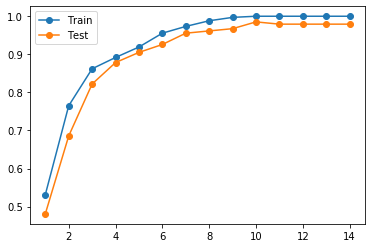

In [37]:
X_train_FE = []
X_test_FE = []
X_train, X_test, y_train, y_test = train_test_split(lines, labels, test_size=0.2, random_state=42)
for i in X_train:
    X_train_FE.append(lpq(i))

for i in X_test:
    X_test_FE.append(lpq(i))
    
#clf = RandomForestClassifier(max_depth=10, random_state=42).fit(X_train_FE, y_train)
#clf.predict_proba(X_test_FE[:1])

clf.predict(X_test_FE)
clf.score(X_train_FE, y_train)
##########################################
#clf = RandomForestClassifier(max_depth=2, random_state=0)
#clf.fit(X, y)
# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 15)]
# evaluate a decision tree for each depth
for i in values:
    clf = RandomForestClassifier(max_depth=i, random_state=42).fit(X_train_FE, y_train)
    # evaluate on the train dataset
    clf.predict(X_train_FE)
    train_acc = clf.score(X_train_FE, y_train)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    clf.predict(X_test_FE)
    test_acc = clf.score(X_test_FE, y_test)
    test_scores.append(test_acc)
    # summarize progress
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()